# Coursework 2 - Part 1



# Outline

- [Task 1](#task-1): Classification with a Convolutional Neural Network <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3, BSc/3rd-year students only)](#task-13b) <a name="index-task-13b"></a>
  - [(1.3, MSc/4th-year students only)](#task-13m) <a name="index-task-13m"></a>
- [Task 2](#task-2): Dimensionality Reduction: PCA vs ISOMAP <a name="index-task-2"></a>
  - [(2.1)](#task-21)
  - [(2.2)](#task-22)
  - [(2.3)](#task-23)  

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
import pandas as pd
from tqdm.notebook import tqdm

# Importing losses, activation functions and layers from PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Sequential, CrossEntropyLoss, Conv2d, MaxPool2d, Flatten, Linear, ReLU, Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn


# we define a mix of fontsizes, for different parts of a plot
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

# example of how you can use these fontsizes to set a global configuration for matplotlib;
# you should assign them based on the specific appearance of the figures you are producing
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

First, I import the data: `star_images_train` and `star_images_test` contain. respectively, 648 and 32 images, each specified by a $32 \times 32$ array. `star_classes_train` and `star_classes_test` contain the corresponding classes of the star images.

In [ ]:
# importing data

star_images_train = np.load('star_images_train.npy')
star_classes_train = np.load('star_classes_train.npy')
star_images_test = np.load('star_images_test.npy')
star_classes_test = np.load('star_classes_test.npy')

classes = ['05V', 'A0V', 'F5V', 'M5V']
value_to_type = {0: 'O5V', 1: 'A0V', 2: 'F5V', 3: 'M5V'}  # mapping of class value to star image type
N = star_images_train.shape[0]  # Number of samples

Mounted at /content/drive


<a name="task-1"></a>

# (1) Task 1: Classification with a Convolutional Neural Network [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

I start by splitting and plotting the data.

In [ ]:
def dataset_split(train_x, train_y, val_size):
    """
    Splits the dataset into training and validation sets.

    Parameters:
    train_x: Dataset input arrays
    train_y: Dataset output value or class
    val_size: Proportion of the total dataset that corresponds to the validation set

    Returns:
    x_train: Training set inputs
    y_train: Training set outputs
    x_val: Validation set inputs
    y_val: Validation set outputs

    """

    indices_train = np.arange(len(train_x))
    np.random.seed(0)
    indices_val = np.random.choice(indices_train, int(len(train_x)*val_size), replace=False) # Key to replace=False, otherwise one gets repeated values!
    indices_train = [idx for idx in indices_train if idx not in indices_val]

    return train_x[indices_train], train_y[indices_train], train_x[indices_val], train_y[indices_val]

val_size = 0.25
x_train, y_train, x_val, y_val = dataset_split(star_images_train, star_classes_train, val_size)
x_test, y_test = star_images_test, star_classes_test

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(486, 32, 32)
(486,)
(162, 32, 32)
(162,)
(32, 32, 32)
(32,)


The input data consists of $32 \times 32$ images. There are 648 training/validation examples and 32 test examples.

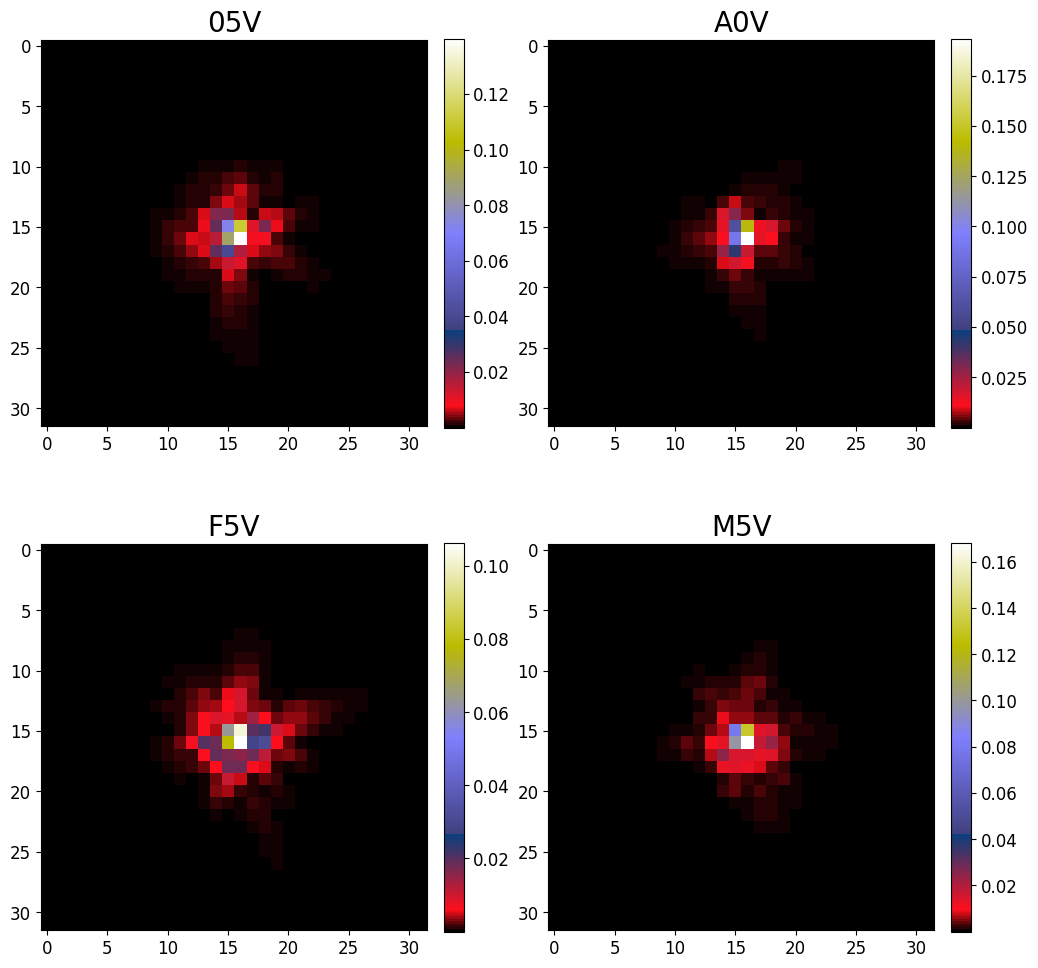

In [ ]:
# Plot a randomly selected example from each class
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for l, label in enumerate(range(len(classes))):
    inx = np.where(y_train == label)[0]
    i = np.random.choice(inx)
    x_example = x_train[i]
    row = l // 2
    col = l % 2
    im = ax[row, col].imshow(x_example, cmap='gist_stern')
    ax[row, col].set_title(classes[l])
    cbar = fig.colorbar(im, ax=ax[row, col], fraction=0.046, pad=0.04)

I build the CNN model in PyTorch to train on the star dataset:

* A `Conv2d` layer with 4 filters, kernel shape of (5, 5) and a `ReLU` activation function
  * L2 weight regularisation with a coefficient to be found through cross-validation in 1.2.
* A `MaxPoo2d` layer with a pooling window size of (2,2) and a stride of 2
* Another `Conv2d` layer with 8 filters, kernel shape of (5, 5) and a `ReLU` activation function
  * L2 weight regularisation with a coefficient to be found through cross-validation in 1.2.
* A `Flatten` layer
* A `Linear` layer and a `Softmax` activation

The function below builds and compiles this model, using an `Adam` optimiser and a `CrossEntropyLoss` criterion.

In [ ]:
class StarCNN(nn.Module):
    def __init__(self, n_filters, k, pool_size, stride_pool, l_in_linear, classes):
        super(StarCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, n_filters, kernel_size=(k,k))
        self.conv2 = nn.Conv2d(n_filters, 2*n_filters, kernel_size=(k,k))
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(pool_size, pool_size), stride=stride_pool)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(l_in_linear, len(classes))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)

        return x

In [ ]:
def get_model(x_train, n_filters, k, pool_size, stride_pool, classes):
    """
    CNN model in PyTorch:
    - Layers are Conv1d(+ReLU), MaxPool1d, Flatten and Linear(+Softmax).
    - It features an Adam optimiser and CrossEntropyLoss criterion.
    - Conv1d and Linear layers have regularised weights according to l2_reg.

    Parameters:
    x_train: Training data
    n_filters: Number of filters to be used in the convolutional layer
    k: Kernel size in the convolutional layer
    pool_size: MaxPool1d window size
    stride_pool: Stride of the MaxPool1d sliding window
    classes: List containing the output classes

    Returns:
    Model, criterion and optimiser.

    """

    l_out_conv1 = x_train.shape[-1] - k + 1 # Length after Conv2d_1 (note that the stride is 1) ## <-- SOLUTION
    l_out_pool1 = (l_out_conv1 - pool_size) // stride_pool + 1 # Length after MaxPool2d_1 ## <-- SOLUTION
    l_out_conv2 = l_out_pool1 - k + 1 # Length after Conv2d_2 ## <-- SOLUTION
    l_in_linear = 2 * n_filters * l_out_conv2 ** 2 # Size before Linear layer ## <-- SOLUTION

    model = StarCNN(n_filters, k, pool_size, stride_pool, l_in_linear, classes)

    criterion = CrossEntropyLoss() ## <-- SOLUTION
    optimiser = torch.optim.Adam(model.parameters()) ## <-- SOLUTION

    return model, criterion, optimiser

In [ ]:
# Run your function to get the model and print it

n_filters = 4
k = 5
pool_size = 2
stride_pool = 2

model, criterion, optimiser = get_model(x_train, n_filters, k, pool_size, stride_pool, classes) ## <-- SOLUTION
print(model)

StarCNN(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=800, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)


Now I am ready to train the model. The `training_loop` function should run the training for `max_num_epochs` of 200 and `batch_size` of 128, featuring early stopping to monitor the validation accuracy. We set the `max_patience` parameter to 150 epochs. The function should return the training and validation history, which includes the loss and accuracy.

In [ ]:
def create_dataloaders(x_train, y_train, x_val, y_val, batch_size=128):
    """
    Converts numpy arrays into PyTorch DataLoader objects for training and validation.

    Parameters:
    x_train: Training set images
    y_train: Training set labels
    x_val: Validation set images
    y_val: Validation set labels
    batch_size: Batch size for DataLoader

    Returns:
    train_loader: DataLoader for training data
    val_loader: DataLoader for validation data

    """
    x_train_tensor = torch.tensor(x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train)
    x_val_tensor = torch.tensor(x_val.reshape(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2]), dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

train_loader, val_loader = create_dataloaders(x_train, y_train, x_val, y_val, batch_size=128)

In [ ]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
    max_patience: Amount of epochs with no improvement after which training is stopped.
    patience: Stores the number of epochs with no improvement.
    best_valid_loss: Stores the current value of the best (minimum) validation loss.
    early_stop: True if training needs to be stopped due to the early stopping condition being met.

    Methods:
    step(val_loss):
        Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=150):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf') ## <-- SOLUTION
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:  ## <-- SOLUTION
            self.best_valid_loss = val_loss  ## <-- SOLUTION
            self.patience = 0  ## <-- SOLUTION
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

In [ ]:
def training_loop(model, train_loader, val_loader, criterion, optimiser, max_num_epochs=200, max_patience=150, reg_strength=0):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
    model: Instance of StarCNN
    train_loader: Training DataLoader
    val_loader: Validation DataLoader
    criterion: Loss function used for training
    optimiser: Optimiser used for training
    max_num_epochs: Maximum number of epochs
    max_patience: max_patience attribute of the EarlyStopping class
    reg_strength: the regularisation parameter

    Returns:
    History.

    """

    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        tr_correct = 0
        val_loss = 0.0
        val_correct = 0

        # Training
        model.train()
        for inputs, labels in train_loader:
            optimiser.zero_grad() # Setting gradients to zero
            outputs = model(inputs)
            loss = criterion(outputs, labels) ## <-- SOLUTION
            #if reg_strength:
            #    loss += reg_strength * (torch.norm(model.conv1.weight, p=2) ** 2 + torch.norm(model.conv2.weight, p=2) ** 2)
            tr_loss += loss.item()
            tr_correct += (outputs.argmax(dim=1) == labels).sum().item() ## <-- SOLUTION
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)

        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_correct/len(train_loader.dataset))

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs_v, labels_v in val_loader:
                outputs_v = model(inputs_v)
                loss_v = criterion(outputs_v, labels_v)  ## <-- SOLUTION
                val_loss += loss_v.item()
                if labels_v.size(0):
                    val_correct += (outputs_v.argmax(dim=1) == labels_v).sum().item() ## <-- SOLUTION

        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_correct/len(val_loader.dataset))

        # Print progress every 50 epochs
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, Training accuracy: {100*tr_correct/len(train_loader.dataset)}%, Validation loss: {val_loss/len(val_loader)}, Validation accuracy: {100*val_correct/len(val_loader.dataset)}%')

        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print("Early stopping acting.")  ## <-- SOLUTION
            break  ## <-- SOLUTION

    return history




---



In [ ]:
# Calling the training loop
max_num_epochs = 2000
max_patience = 150

model, criterion, optimiser = get_model(x_train, n_filters, k, pool_size, stride_pool, classes) ## <-- SOLUTION
history = training_loop(model, train_loader, val_loader, criterion, optimiser, max_num_epochs, max_patience)

Epoch 1/2000, Training loss: 1.3873761296272278, Training accuracy: 23.662551440329217%, Validation loss: 1.3873851895332336, Validation accuracy: 25.308641975308642%
Epoch 50/2000, Training loss: 1.3849241137504578, Training accuracy: 26.954732510288064%, Validation loss: 1.3877984285354614, Validation accuracy: 25.308641975308642%
Epoch 100/2000, Training loss: 1.381636142730713, Training accuracy: 26.954732510288064%, Validation loss: 1.3845093846321106, Validation accuracy: 25.308641975308642%
Epoch 150/2000, Training loss: 1.3414779901504517, Training accuracy: 42.38683127572016%, Validation loss: 1.3380702137947083, Validation accuracy: 40.74074074074074%
Epoch 200/2000, Training loss: 1.2551804780960083, Training accuracy: 51.02880658436214%, Validation loss: 1.2581475377082825, Validation accuracy: 48.148148148148145%
Epoch 250/2000, Training loss: 1.2088124752044678, Training accuracy: 51.851851851851855%, Validation loss: 1.2196643352508545, Validation accuracy: 49.3827160493

I now analyse convergence:

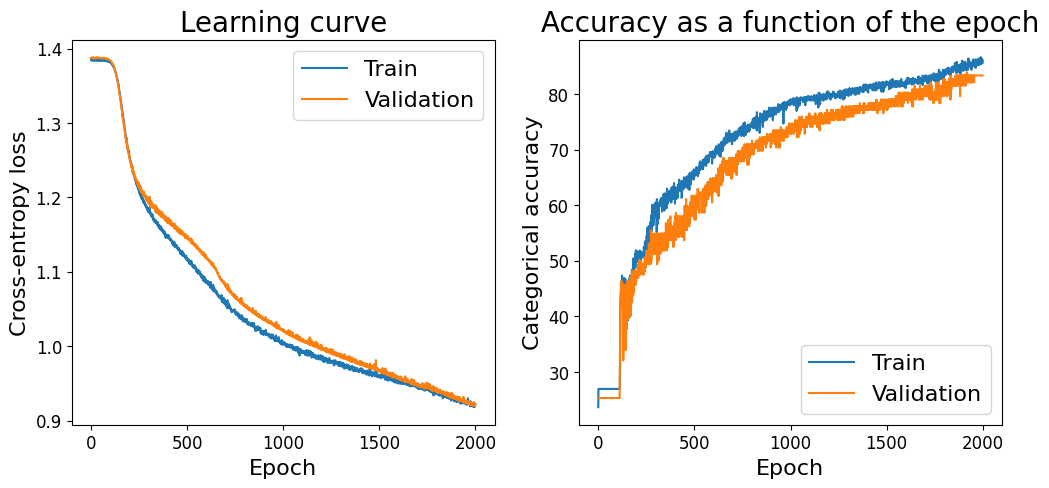

In [ ]:
def plot_loss_accuracy(history):
    """
    Plots of training and validation loss and accuracy over epochs.

    Parameters:
    history: Dictionary containing 'training_loss', 'validation_loss', 'training_accuracy', and 'validation_accuracy' lists.

    """

    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(121)
    plt.plot(history['training_loss'], label='Train')
    plt.plot(history['validation_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.title('Learning curve')
    plt.legend()

    fig.add_subplot(122)
    plt.plot(history['training_accuracy'], label='Train')
    plt.plot(history['validation_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Categorical accuracy')
    plt.title('Accuracy as a function of the epoch')
    plt.legend()

    plt.show()

plot_loss_accuracy(history)

I can see from the plot on the left that the validation loss closely follows the trend of the training loss, suggesting that the model is generalising well rather than overfitting to the training data. As both losses appear to keep decreasing towards the end, by just looking at this plot we might decide to train further to see if they fully *plateau*.

The accuracy plot also reflects this pattern: the validation accuracy remains closely aligned with the training accuracy throughout the training process. Moreover, here one can see stabilisation towards the end, indicating that the model has reached its learning capacity and achieved convergence.

In [ ]:
def evaluate_model(model, x_test, y_test):
    """
    Computes the accuracy of the model on the test set.

    Parameters:
    model: Instance of StarCNN
    x_test: Test set inputs
    y_test: Test set outputs

    """

    x_test_tensor = torch.tensor(x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test)

    model.eval()
    with torch.no_grad():
        outputs = model(x_test_tensor)
        accuracy = (outputs.argmax(dim=1) == y_test_tensor).sum().item() / len(y_test) * 100
    return accuracy

test_accuracy = evaluate_model(model, x_test, y_test)
print(f'The test accuracy is {test_accuracy}%.')

The test accuracy is 84.375%.


<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

Now I scan over values $0.001$, $0.01$, $0.1$, $1$, and $10$ to find the optimal regularisation strength. Note that the loss function was adapted in the training loop to penalise the weights of the convolutional layers.

In [ ]:
reg_strength_list = [0.001, 0.01, 0.1, 1, 10]
val_acc_list = []

for reg_strength in reg_strength_list:
    print('For regularisation strength =', reg_strength)
    model, criterion, optimiser = get_model(x_train, n_filters, k, pool_size, stride_pool, classes) ## <-- SOLUTION
    history = training_loop(model, train_loader, val_loader, criterion, optimiser, max_num_epochs, max_patience, reg_strength=reg_strength)
    val_acc_list.append(history['validation_accuracy'][-1])
    print('Validation accuracy (%) =', val_acc_list[-1])

opt_reg_strength = reg_strength_list[np.argmax(val_acc_list)]
print('The optimal regularisation strength is', opt_reg_strength)

For regularisation strength = 0.001
Epoch 1/2000, Training loss: 1.3864969611167908, Training accuracy: 24.48559670781893%, Validation loss: 1.3856018781661987, Validation accuracy: 25.925925925925927%
Epoch 50/2000, Training loss: 1.3781791031360626, Training accuracy: 27.77777777777778%, Validation loss: 1.3787543177604675, Validation accuracy: 28.395061728395063%
Epoch 100/2000, Training loss: 1.2903965711593628, Training accuracy: 45.267489711934154%, Validation loss: 1.266484260559082, Validation accuracy: 46.91358024691358%
Epoch 150/2000, Training loss: 1.2224999964237213, Training accuracy: 48.559670781893004%, Validation loss: 1.2050364017486572, Validation accuracy: 48.76543209876543%
Epoch 200/2000, Training loss: 1.1890761852264404, Training accuracy: 57.61316872427984%, Validation loss: 1.1812325716018677, Validation accuracy: 54.93827160493827%
Epoch 250/2000, Training loss: 1.1668757200241089, Training accuracy: 61.111111111111114%, Validation loss: 1.168241798877716, Va



---



The optimal regularisation strength is determined by looking at the scenario in which the validation accuracy is maximised. In this case, the optimal value is 1. I now proceed to re-train the CNN on the training set and evaluate the classification accuracy on the test set.

In [ ]:
model, criterion, optimiser = get_model(x_train, n_filters, k, pool_size, stride_pool, classes) ## <-- SOLUTION
history = training_loop(model, train_loader, val_loader, criterion, optimiser, max_num_epochs, max_patience, reg_strength=opt_reg_strength)

Epoch 1/2000, Training loss: 1.3862003087997437, Training accuracy: 26.954732510288064%, Validation loss: 1.3863494992256165, Validation accuracy: 25.308641975308642%
Epoch 50/2000, Training loss: 1.3850637078285217, Training accuracy: 26.954732510288064%, Validation loss: 1.3875056505203247, Validation accuracy: 25.308641975308642%
Epoch 100/2000, Training loss: 1.3823752403259277, Training accuracy: 26.954732510288064%, Validation loss: 1.385685682296753, Validation accuracy: 25.308641975308642%
Epoch 150/2000, Training loss: 1.3568438291549683, Training accuracy: 35.59670781893004%, Validation loss: 1.357023000717163, Validation accuracy: 34.5679012345679%
Epoch 200/2000, Training loss: 1.2996405363082886, Training accuracy: 40.32921810699588%, Validation loss: 1.2944279909133911, Validation accuracy: 37.03703703703704%
Epoch 250/2000, Training loss: 1.2610729038715363, Training accuracy: 42.181069958847736%, Validation loss: 1.256291925907135, Validation accuracy: 41.35802469135802

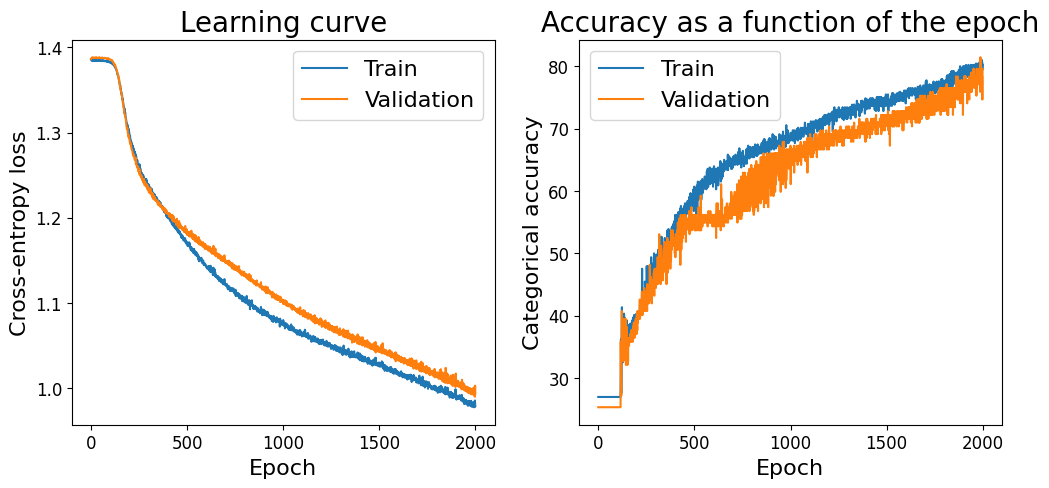

In [ ]:
plot_loss_accuracy(history)

In [ ]:
test_accuracy = evaluate_model(model, x_test, y_test)
print(f'The test accuracy is {test_accuracy}%.')

The test accuracy is 81.25%.


Training the CNN with L2 regularisation at its optimal strength results in a slight performance drop. In this case, convergence is not evident, but the separation between training and validation learning curves remains similar to the previous case. This suggests that additional training may be required for better stability and performance.

<a name="task-13b"></a>

## (1.3, BSc/3rd-year students only) [(index)](#index-task-13b)


I create the requested imbalanced training set by randomly dropping half of the data points in class 3 (M5V) from the original training set. I split the resulting dataset into 75% for actual training and 25% for validation.

Epoch 1/2000, Training loss: 1.3874859511852264, Training accuracy: 19.953051643192488%, Validation loss: 1.3867103457450867, Validation accuracy: 21.830985915492956%
Epoch 50/2000, Training loss: 1.3563565015792847, Training accuracy: 30.985915492957748%, Validation loss: 1.4094905853271484, Validation accuracy: 21.830985915492956%
Epoch 100/2000, Training loss: 1.3505320847034454, Training accuracy: 30.516431924882628%, Validation loss: 1.4114484190940857, Validation accuracy: 21.830985915492956%
Epoch 150/2000, Training loss: 1.3535517156124115, Training accuracy: 30.985915492957748%, Validation loss: 1.413402497768402, Validation accuracy: 21.830985915492956%
Early stopping acting.


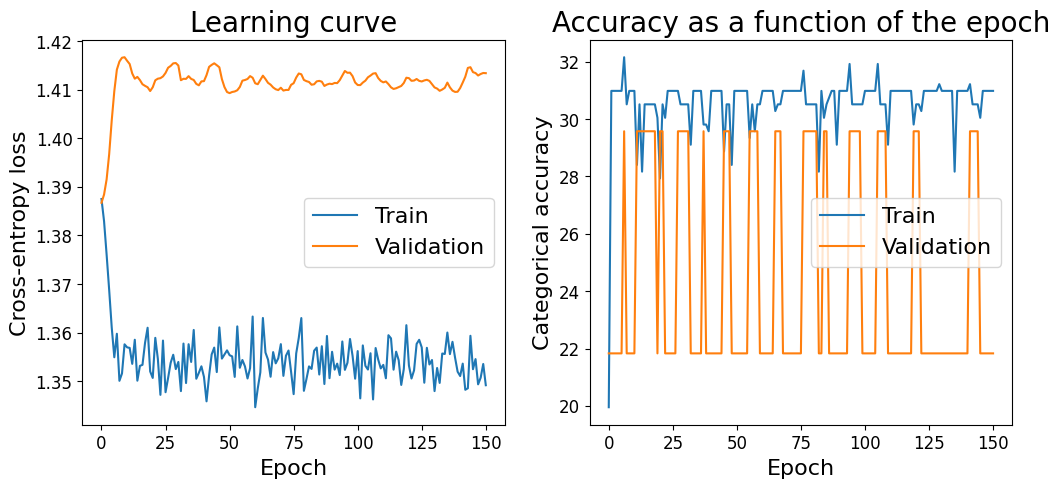

In [ ]:
np.random.seed(0)
class_3_indices = np.where(star_classes_train == 3)[0]
selected_indices = np.random.choice(class_3_indices, len(class_3_indices) // 2, replace=False)
remaining_indices = np.setdiff1d(np.arange(len(star_classes_train)), selected_indices)

x_train_imbalanced = star_images_train[remaining_indices]
y_train_imbalanced = star_classes_train[remaining_indices]

x_train, y_train, x_val, y_val = dataset_split(x_train_imbalanced, y_train_imbalanced, val_size)
train_loader, val_loader = create_dataloaders(x_train, y_train, x_val, y_val, batch_size=128)
model, criterion, optimiser = get_model(x_train, n_filters, k, pool_size, stride_pool, classes)
history_imbalanced = training_loop(model, train_loader, val_loader, criterion, optimiser, max_num_epochs, max_patience)
plot_loss_accuracy(history_imbalanced)

Now the performance has drastically dropped. I modify the loss function by assigning the weight of each class to be the reciprocal of the class frequency.

Epoch 1/2000, Training loss: 1.3835818767547607, Training accuracy: 24.88262910798122%, Validation loss: 1.3895622491836548, Validation accuracy: 29.577464788732396%
Epoch 50/2000, Training loss: 1.3573632836341858, Training accuracy: 30.985915492957748%, Validation loss: 1.4112478494644165, Validation accuracy: 21.830985915492956%
Epoch 100/2000, Training loss: 1.3530766367912292, Training accuracy: 30.516431924882628%, Validation loss: 1.415050446987152, Validation accuracy: 29.577464788732396%
Epoch 150/2000, Training loss: 1.3541627824306488, Training accuracy: 30.985915492957748%, Validation loss: 1.4139904379844666, Validation accuracy: 21.830985915492956%
Early stopping acting.


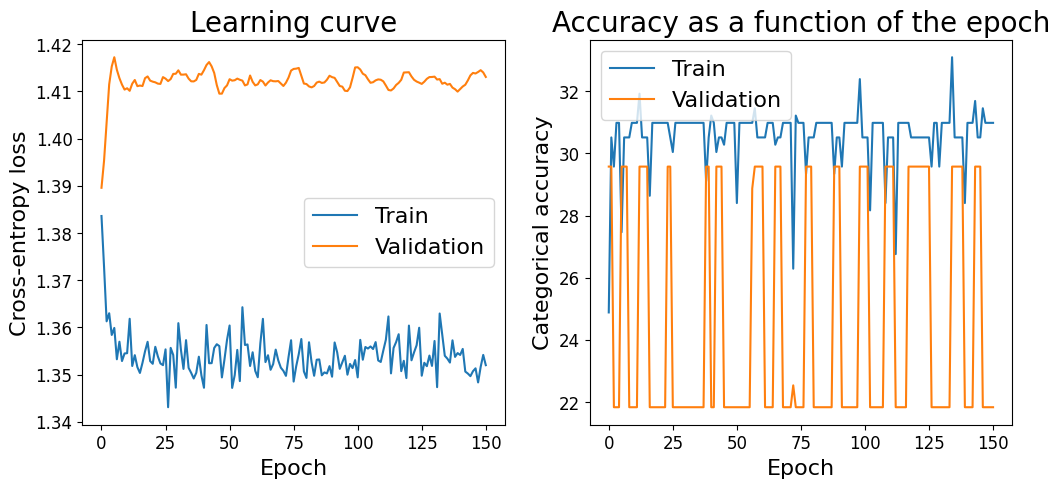

In [ ]:
weights = torch.tensor(1.0 / np.bincount(y_train), dtype=torch.float32)
criterion_weighted = CrossEntropyLoss(weight=weights)

model_weighted, criterion_weighted, optimiser_weighted = get_model(x_train, n_filters, k, pool_size, stride_pool, classes)
history_weighted = training_loop(model_weighted, train_loader, val_loader, criterion_weighted, optimiser_weighted, max_num_epochs, max_patience)
plot_loss_accuracy(history_weighted)

Utilising a reweighted loss function does not seem to be enough to recover performance. As a second approach, I produce new training data of the minority class (Class 3) by using each image in the depleted class 3 to obtain an additional training image by adding Gaussian noise on each pixel drawn from the Gaussian distribution. I scan several noise levels and find the optimal value of $c$ by cross-validation by looking at the highest validation accuracy.

In [ ]:
c_values = [0.01, 0.1, 1]
optimal_c = None
best_val_acc = 0

for c in c_values:
    print('For c =', c)
    noise = np.random.normal(0, np.sqrt(c) * np.std(x_train_imbalanced[y_train_imbalanced == 3], axis=0), x_train_imbalanced[y_train_imbalanced == 3].shape)
    x_augmented = np.clip(x_train_imbalanced[y_train_imbalanced == 3] + noise, 0, 1)
    y_augmented = np.full(len(x_augmented), 3)

    x_train_augmented = np.concatenate((x_train_imbalanced, x_augmented), axis=0)
    y_train_augmented = np.concatenate((y_train_imbalanced, y_augmented), axis=0)

    x_train_aug, y_train_aug, x_val_aug, y_val_aug = dataset_split(x_train_augmented, y_train_augmented, val_size)
    train_aug_loader, val_aug_loader = create_dataloaders(x_train_aug, y_train_aug, x_val_aug, y_val_aug, batch_size=128)

    model_aug, criterion_aug, optimiser_aug = get_model(x_train, n_filters, k, pool_size, stride_pool, classes)
    history_aug = training_loop(model_aug, train_aug_loader, val_aug_loader, criterion_aug, optimiser_aug, max_num_epochs, max_patience)
    print('Validation accuracy (%) =', history_aug['validation_accuracy'][-1])

    if history_aug['validation_accuracy'][-1] > best_val_acc:
        best_val_acc = history_aug['validation_accuracy'][-1]
        optimal_c = c

For c = 0.01
Epoch 1/2000, Training loss: 1.3866592049598694, Training accuracy: 24.640657084188913%, Validation loss: 1.3859768509864807, Validation accuracy: 23.45679012345679%
Epoch 50/2000, Training loss: 1.3843060433864594, Training accuracy: 27.515400410677618%, Validation loss: 1.3880763053894043, Validation accuracy: 23.45679012345679%
Epoch 100/2000, Training loss: 1.3844611048698425, Training accuracy: 27.515400410677618%, Validation loss: 1.3875165581703186, Validation accuracy: 23.45679012345679%
Epoch 150/2000, Training loss: 1.3825713396072388, Training accuracy: 27.515400410677618%, Validation loss: 1.3852185606956482, Validation accuracy: 23.45679012345679%
Epoch 200/2000, Training loss: 1.3359038829803467, Training accuracy: 42.299794661190965%, Validation loss: 1.3329736590385437, Validation accuracy: 40.123456790123456%
Epoch 250/2000, Training loss: 1.2658808529376984, Training accuracy: 45.58521560574949%, Validation loss: 1.2599026560783386, Validation accuracy: 4

I find that the optimal value of $c$ is the lowest considered, *i.e.*, 0.01. This suggests that adding noise with a low standard deviation is enough for the data augmentation approach to improve model performance. As the noise level increases, the model continues to perform reasonably well, but accuracy declines. This is likely because higher noise levels obscure the relationship between the images and their respective classes, making classification more challenging.

Epoch 1/2000, Training loss: 1.3852925539016723, Training accuracy: 29.06764168190128%, Validation loss: 1.3811509609222412, Validation accuracy: 32.417582417582416%
Epoch 50/2000, Training loss: 1.3641515254974366, Training accuracy: 33.45521023765996%, Validation loss: 1.380053460597992, Validation accuracy: 32.417582417582416%
Epoch 100/2000, Training loss: 1.3729395866394043, Training accuracy: 33.45521023765996%, Validation loss: 1.378492295742035, Validation accuracy: 32.417582417582416%
Epoch 150/2000, Training loss: 1.37204110622406, Training accuracy: 33.45521023765996%, Validation loss: 1.378914713859558, Validation accuracy: 32.417582417582416%
Epoch 200/2000, Training loss: 1.3147154092788695, Training accuracy: 35.831809872029254%, Validation loss: 1.3280017375946045, Validation accuracy: 34.065934065934066%
Epoch 250/2000, Training loss: 1.2229297637939454, Training accuracy: 48.62888482632541%, Validation loss: 1.224100649356842, Validation accuracy: 48.35164835164835%
E

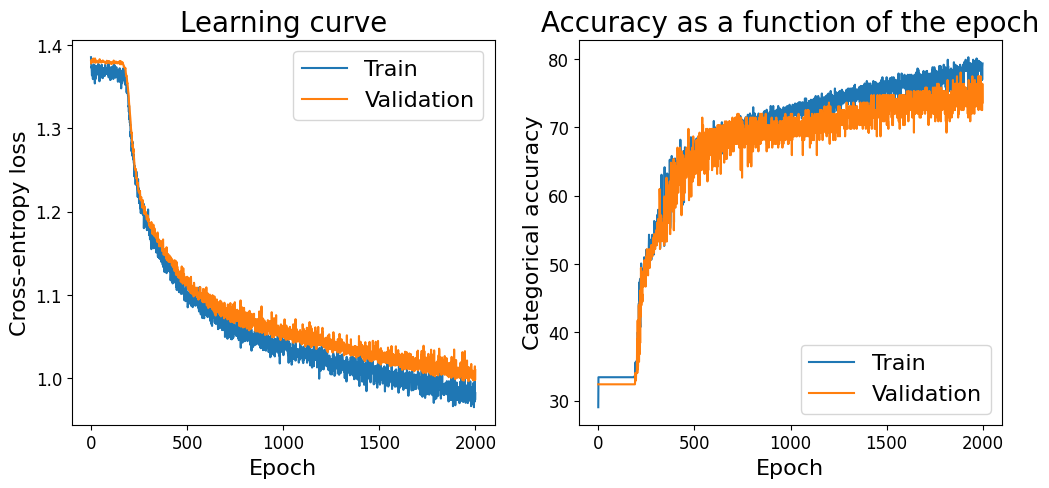

In [ ]:
noise_optimal = np.random.normal(0, np.sqrt(optimal_c) * np.std(star_images_train[class_3_indices], axis=0), star_images_train[class_3_indices].shape)
x_augmented_optimal = np.clip(star_images_train[class_3_indices] + noise_optimal, 0, 1)
y_augmented_optimal = np.full(len(x_augmented_optimal), 3)

x_train_da = np.concatenate((x_train_imbalanced, x_augmented_optimal), axis=0)
y_train_da = np.concatenate((y_train_imbalanced, y_augmented_optimal), axis=0)

x_train_da, y_train_da, x_val_da, y_val_da = dataset_split(x_train_da, y_train_da, val_size)
train_da_loader, val_da_loader = create_dataloaders(x_train_da, y_train_da, x_val_da, y_val_da, batch_size=128)

model_da, criterion_da, optimiser_da = get_model(x_train, n_filters, k, pool_size, stride_pool, classes)
history_da = training_loop(model_da, train_da_loader, val_da_loader, criterion_da, optimiser_da, max_num_epochs, max_patience)
plot_loss_accuracy(history_da)

In this case, we observe that all loss and accuracy curves reach a *plateau*. Finally, we evaluate the accuracies of three models: the initial model trained on a depleted Class 3 dataset without any class imbalance mitigation, the model trained with a reweighted loss function, and the model trained using data augmentation with Gaussian noise.

In [ ]:
accuracy_imbalanced = evaluate_model(model, x_test, y_test)
accuracy_weighted = evaluate_model(model_weighted, x_test, y_test)
accuracy_da = evaluate_model(model_da, x_test, y_test)

print('Test Accuracies:')
print(f'Imbalanced model: {accuracy_imbalanced:.2f}%')
print(f'Reweighted loss model: {accuracy_weighted:.2f}%')
print(f'Data augmentation model: {accuracy_da:.2f}%')


Test Accuracies:
Imbalanced model: 25.00%
Reweighted loss model: 25.00%
Data augmentation model: 81.25%


Our results indicate that the best-performing model was the initial one, trained without regularisation and the original (balanced) dataset. While regularisation can help in overfitting scenarios, it did not provide a clear advantage here, though overall performance remained comparably high. When training on an imbalanced dataset without any mitigation strategies, accuracy dropped significantly, approaching a random guessing situation. Reweighting the loss to give more importance to the minority class proved insufficient to fully address the imbalance. However, augmenting the dataset by adding noise to duplicated samples of the depleted class led to a substantial improvement in accuracy, demonstrating the effectiveness of data augmentation in this context.


  <a name="task-13m"></a>

## (1.3, MSc/4th-year students only) [(index)](#index-task-13m)

I create the requested imbalanced training set by randomly dropping half of the data points in class 3 (M5V) from the original training set. I split the resulting dataset into 75% for actual training and 25% for validation.

Epoch 1/2000, Training loss: 1.3859215378761292, Training accuracy: 30.046948356807512%, Validation loss: 1.3867107033729553, Validation accuracy: 29.577464788732396%
Epoch 50/2000, Training loss: 1.3474411070346832, Training accuracy: 30.985915492957748%, Validation loss: 1.4110147953033447, Validation accuracy: 21.830985915492956%
Epoch 100/2000, Training loss: 1.357706069946289, Training accuracy: 30.985915492957748%, Validation loss: 1.4128751754760742, Validation accuracy: 21.830985915492956%
Epoch 150/2000, Training loss: 1.3552295863628387, Training accuracy: 30.046948356807512%, Validation loss: 1.41303288936615, Validation accuracy: 29.577464788732396%
Early stopping acting.


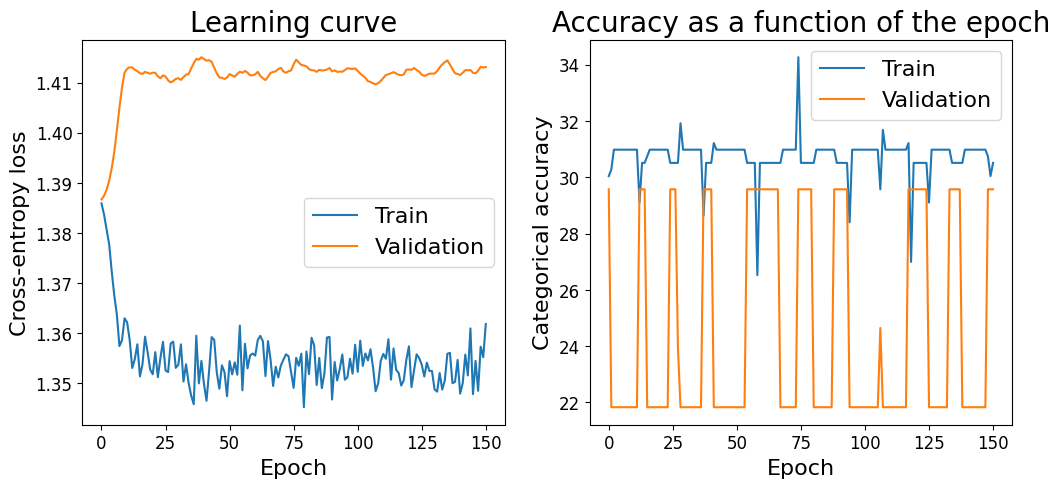

In [ ]:
np.random.seed(0)
class_3_indices = np.where(star_classes_train == 3)[0]
selected_indices = np.random.choice(class_3_indices, len(class_3_indices) // 2, replace=False)
remaining_indices = np.setdiff1d(np.arange(len(star_classes_train)), selected_indices)

x_train_imbalanced = star_images_train[remaining_indices]
y_train_imbalanced = star_classes_train[remaining_indices]

x_train, y_train, x_val, y_val = dataset_split(x_train_imbalanced, y_train_imbalanced, val_size)
train_loader, val_loader = create_dataloaders(x_train, y_train, x_val, y_val, batch_size=128)
model, criterion, optimiser = get_model(x_train, n_filters, k, pool_size, stride_pool, classes)
history_imbalanced = training_loop(model, train_loader, val_loader, criterion, optimiser, max_num_epochs, max_patience)
plot_loss_accuracy(history_imbalanced)

Now the performance has drastically dropped. I modify the loss function by assigning the weight of each class to be the reciprocal of the class frequency.

Epoch 1/2000, Training loss: 1.384799212217331, Training accuracy: 30.516431924882628%, Validation loss: 1.3875991702079773, Validation accuracy: 29.577464788732396%
Epoch 50/2000, Training loss: 1.3561919927597046, Training accuracy: 30.516431924882628%, Validation loss: 1.4129433035850525, Validation accuracy: 29.577464788732396%
Epoch 100/2000, Training loss: 1.3586541414260864, Training accuracy: 31.92488262910798%, Validation loss: 1.41041499376297, Validation accuracy: 29.577464788732396%
Epoch 150/2000, Training loss: 1.3508824408054352, Training accuracy: 30.516431924882628%, Validation loss: 1.4142815470695496, Validation accuracy: 29.577464788732396%
Early stopping acting.


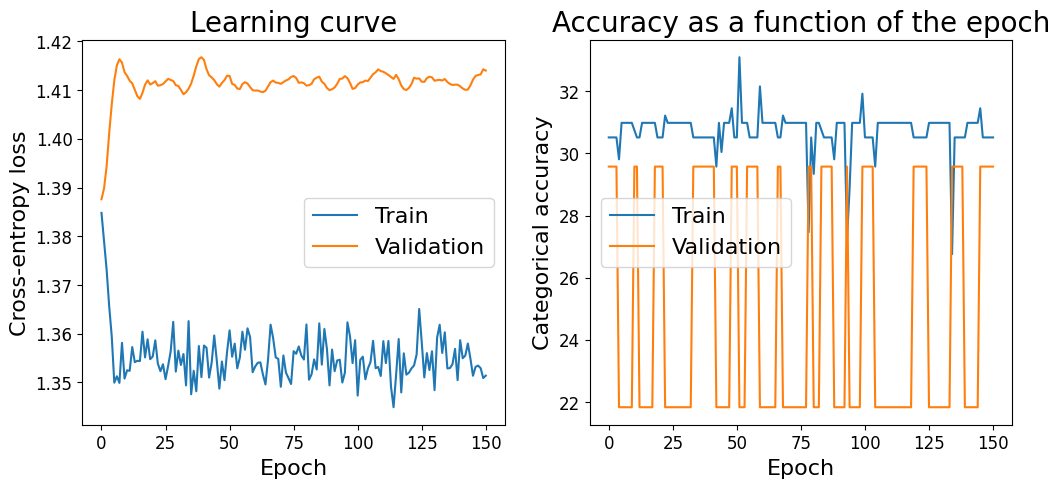

In [ ]:
weights = torch.tensor(1.0 / np.bincount(y_train), dtype=torch.float32)
criterion_weighted = CrossEntropyLoss(weight=weights)

model_weighted, criterion_weighted, optimiser_weighted = get_model(x_train, n_filters, k, pool_size, stride_pool, classes)
history_weighted = training_loop(model_weighted, train_loader, val_loader, criterion_weighted, optimiser_weighted, max_num_epochs, max_patience)
plot_loss_accuracy(history_weighted)

Utilising a reweighted loss function does not seem to be enough to recover performance. As a second approach, I produce new training data of the minority class (Class 3) by using each image in the depleted class 3 to obtain one additional training image by rotating it, choosing uniformly at random a rotation of either 90, 180, or 270 degrees.

Epoch 1/2000, Training loss: 1.3863845765590668, Training accuracy: 26.995305164319248%, Validation loss: 1.386878252029419, Validation accuracy: 29.577464788732396%
Epoch 50/2000, Training loss: 1.348781168460846, Training accuracy: 30.985915492957748%, Validation loss: 1.4106300473213196, Validation accuracy: 21.830985915492956%
Epoch 100/2000, Training loss: 1.3510749340057373, Training accuracy: 28.4037558685446%, Validation loss: 1.4122640490531921, Validation accuracy: 21.830985915492956%
Epoch 150/2000, Training loss: 1.3585185110569, Training accuracy: 30.985915492957748%, Validation loss: 1.411691665649414, Validation accuracy: 21.830985915492956%
Early stopping acting.


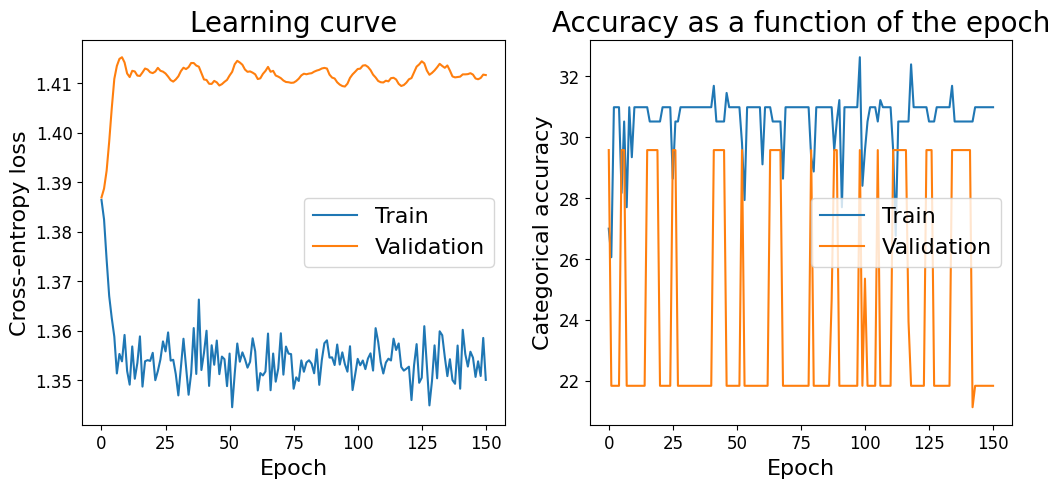

In [ ]:
x_augmented = np.concatenate([np.rot90(x_train_imbalanced[y_train_imbalanced == 3], k=angle, axes=(1, 2)) for angle in [1, 2, 3]], axis=0)
y_augmented = np.full(len(x_augmented), 3)

x_train_da = np.concatenate((x_train_imbalanced, x_augmented), axis=0)
y_train_da = np.concatenate((y_train_imbalanced, y_augmented), axis=0)

x_train_da, y_train_da, x_val_da, y_val_da = dataset_split(x_train_da, y_train_da, val_size)
train_da_loader, val_da_loader = create_dataloaders(x_train_da, y_train_da, x_val_da, y_val_da)

model_da, criterion_da, optimiser_da = get_model(x_train, n_filters, k, pool_size, stride_pool, classes)
history_da = training_loop(model_da, train_loader, val_loader, criterion_da, optimiser_da, max_num_epochs, max_patience)
plot_loss_accuracy(history_da)

 While CNNs are designed to be invariant to transformations like rotations, the considered augmentation approach does not add meaningful diversity to the dataset. Instead of introducing new features, it provides more of the same information in a different orientation, which does not help the model learn better class representations.

In [ ]:
accuracy_imbalanced = evaluate_model(model, x_test, y_test)
accuracy_weighted = evaluate_model(model_weighted, x_test, y_test)
accuracy_da = evaluate_model(model_da, x_test, y_test)

print('Test Accuracies:')
print(f'Imbalanced model: {accuracy_imbalanced:.2f}%')
print(f'Reweighted loss model: {accuracy_weighted:.2f}%')
print(f'Data augmentation model: {accuracy_da:.2f}%')

Test Accuracies:
Imbalanced model: 25.00%
Reweighted loss model: 25.00%
Data augmentation model: 25.00%


Our results indicate that the best-performing model was the initial one, trained without regularisation and the original (balanced) dataset. While regularisation can help in overfitting scenarios, it did not provide a clear advantage here, though overall performance remained comparably high. When training on an imbalanced dataset without any mitigation strategies, accuracy dropped significantly, approaching a random guessing situation. Neither reweighting the loss to emphasise the minority class nor augmenting the dataset with rotated images was sufficient to effectively mitigate the class imbalance.



---



<a name="task-2"></a>

# (2) Task 2: Dimensionality Reduction: PCA vs ISOMAP [(index)](#index-task-2)

I import `star_embeddings_train` $648$ $180$-dimensional embeddings of the star images in the training set, one for each star. I will perform dimensionality reduction of these embeddings. As illustration, I plot the first ttwo dimensions using the star class as colour.

In [ ]:
X = np.load(PATH + 'star_embeddings_train.npy')
classes = [0, 1, 2, 3]

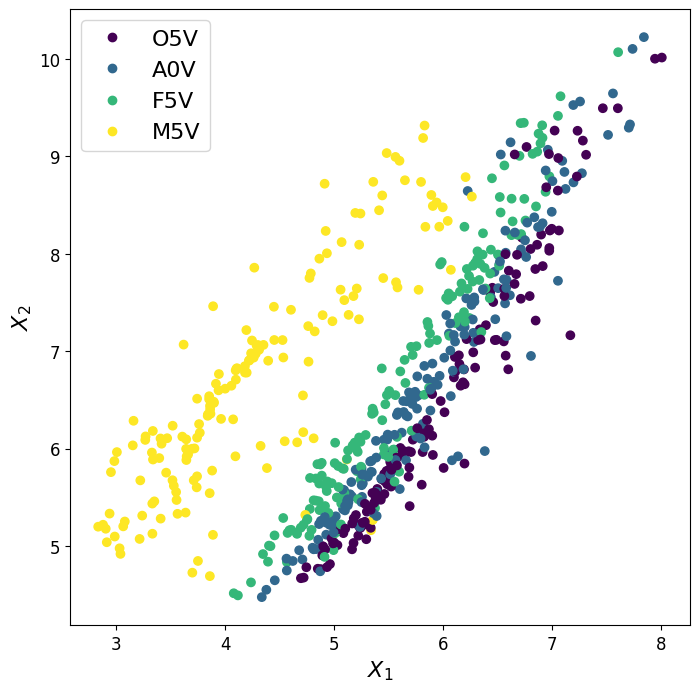

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
scatter = plt.scatter(X[:,0], X[:,1], c=star_classes_train)
legend = plt.legend(handles=scatter.legend_elements()[0], labels=[value_to_type[c] for c in classes])

for handle, label in zip(legend.legend_handles, star_classes_train):
    handle.set_label(label)
plt.xlabel(u'$X_1$')
plt.ylabel(u'$X_2$')
plt.show()

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)


I first standardise the data (obtaining `X_std`) for use in PCA.

In [ ]:
def standardise(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Standardised data.

    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std==0] = 1.
    Xbar = (X - mu) / std

    return Xbar

In [ ]:
X_std = standardise(X)

Now I perform PCA - a dimensionality reduction technique consisting of projecting the data on the directions of maximal variance.

To this end, I compute the data covariance matrix `C` and then I diagonalise it to find its `m` largest eigevalues and corresponding eigenvectors - the principal components. The coordinates of the data projected onto the first `m` principal components are stored in the matrix `X_PCA`; here I take `m= 2`.

First, I import the functions to perform PCA from the coding tasks.

In [ ]:
def covariance_matrix(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Computes the data covariance matrix.

    """
    return np.dot(X.T, X) / len(X)

def pca_function(X, k):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
    k: Number of principal components.

    Returns:
    X_pca: Transformed data.
    eigenvectors: First k eigenvectors of C.
    eigenvalues: First k eigenvalues of C.

    """
    # Computing the covariance matrix
    C = covariance_matrix(X)

    # Computing the eigenvalues and eigenvectors using the eigsh scipy function
    eigen = linalg.eigh(C)

    # extract the k principle components and eigenvalues
    eigenvalues = eigen.eigenvalues[::-1][0:k]
    eigenvectors = eigen.eigenvectors[:, ::-1][:, 0:k]

    # Projecting the data onto the directions of eigenvectors
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

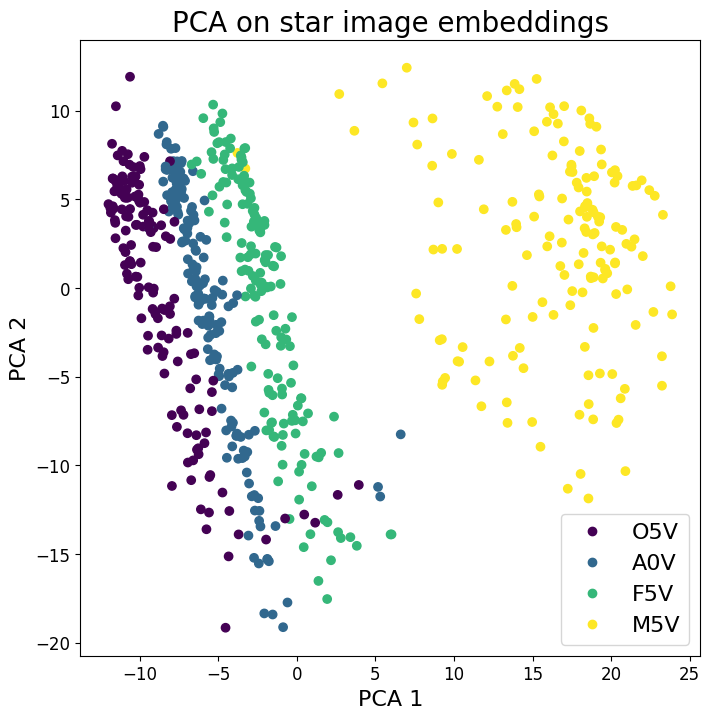

In [ ]:
# Compute first two principal components
X_pca, _, _ = pca_function(X_std, 2)

# plot
fig, ax = plt.subplots(figsize=(8,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=star_classes_train)
legend = plt.legend(handles=scatter.legend_elements()[0], labels=[value_to_type[c] for c in classes])

for handle, label in zip(legend.legend_handles, star_classes_train):
    handle.set_label(label)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'PCA on star image embeddings')
plt.show()

From the plot of the projection of the star embeddings onto the space of the first two principal components, one observes that data points from class M5V tend to cluster away from the other classes (O5V, A0V, F5V).

This suggests that there are some similarities between data in these latter classes, and conversely that the discriminative features between classes are not fully captured by the first two principal components. Hence, the PCA lower-dimensional representation might not be very effective at facilitating classification, especially in connection to these 3 classes. A non-linear dimensionality reduction method might be needed to obtain a dimensionality reduction that is more effective in this regard.

To quantitate how well the PCA representation reflects the separation into classes, I next compute the Davies-Bouldin (DB) Index.

I define a function `davies_bouldin_index` to calculate the DB Index. Its steps are as follows:

1. Given the data and their cluster labels, compute the centroids of each cluster like in $K$-means, i.e., each coordinate of the centroid is the average coordinate across points in that cluster.

2. For each cluster $\alpha$, compute $S_{\alpha}$ as the the average Euclidean distance between each point of cluster and the centroid of that cluster.

3. For each pair of clusters $\alpha$ and $\beta$, compute $M_{\alpha \beta}$ as the Euclidean distance between the centroids of clusters.

4. Compute $F_{\alpha \beta} = \frac{S_{\alpha} + S_{\beta}}{M_{\alpha\beta}}$, which summarises the trade-off of within-cluster cohesion and the between-clusters separation, for two clusters $\alpha$ and $\beta$.

5. Compute `davies_bouldin_index` as $\frac{1}{C} \sum_{\alpha=1}^C \text{max}_{\beta, \beta \neq \alpha} F_{\alpha \beta}$, i.e., as an average over clusters of the maximum of $F_{\alpha \beta}$ across clusters' pairwise comparisons.

In [ ]:
def davies_bouldin_index(X, labels):
    """Compute the Davies-Bouldin index (DBI) for a given clustering given the data and the labels.

     Args:
        X (np.ndarray): the samples array, shape: (N, p).
        labels (np.ndarray): the labels array, shape: (N,).

    Returns:
        float: the DB Index.
    """

    # Compute the centroids of the clusters, given the data and their labels
    labels_unique = np.unique(labels)
    centroids = np.array([np.mean(X[labels == i], axis=0) for i in labels_unique])

    # Compute S_alpha for each cluster alpha
    S = np.array([np.mean(np.linalg.norm(X[labels == i] - centroids[i], axis=1)) for i in labels_unique])

    # Compute M_alpha,beta
    M = np.array([[np.linalg.norm(centroids[i] - centroids[j]) for j in labels_unique] for i in labels_unique])

    # Compute F_alpha
    F = np.zeros_like(M)
    for i in range(len(labels_unique)):
        for j in range(i+1, len(labels_unique)):
            F[i, j] = F[j, i] = (S[i] + S[j]) / M[i, j]

    # compute the DB index
    DB_index = np.mean([np.max(F[i][np.arange(len(centroids)) != i]) for i in range(len(centroids))])
    return DB_index

In [ ]:
db_pca = davies_bouldin_index(X_pca, star_classes_train)
print(f'Davies bouldin index for the PCA dimensionality reduction of star image embeddings: {db_pca:.2f}')

Davies bouldin index for the PCA dimensionality reduction of star image embeddings: 2.85


The DB index gives an average of the maximal ratios of within-cluster distance and inter-cluster distance. Since in clustering the within-cluster distance should be minimised and the inter-cluster distance should be maximised, then the DB index gives in average the worst clustering performance across pairs of clusters. Hence, low values of the DB index is indication of compact,  well-separated clusters, hence of good clustering performance.

A DB index of `2.85` suggests that the clustering performance is not high, indicating in this case that the PCA representation does not reflect very well the separation into classes. It essentially indicates high intra-cluster distance, evident already by visual inspection. This is probably because PCA projects the data onto the directions of maximal variance in the data, which would give rise to a good clustering by class if the separation between classes occurs in these directions, i.e., if points from different classes tend to differ in this projection. But here, as undelined above, points from the 3 classes O5V, A0V, F5V have a similar projection on both PCs (only the projection onto PC1 has some difference between these classes), and this is picked up in a value of the DB index typical of moderate clustering performance.

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

Here I implement another dimensionality reduction algorithm based on a variant of ISOMAP, which is a dimensionality reduction technique based on graph learning.

The first step is the graph construction, whose steps are as follows.
1. Compute the matrix of cosine distances between each pair of samples (here, the star embeddings), where the pairwise cosine distance $D_{ij}$ between $X_i$ and $X_j$ is given by:

$$
D_{ij} = 1 - \frac{X_i \cdot X_j}{||X_i||_2||X_j||_2}
$$

2. Construct the adjacency matrix via the $k$-Nearest Neighbour ($k$NN) graph construction method with $k=9$, where two samples $X_i$ and $X_j$ are connected with an undirected edge of weight $D_{ij}$ if $X_i$ is within the $k$-nearest neighbours of $X_j$ and viceversa. I write the function `compute_kNN` for this step.

In [ ]:
# Computation of the cosine distances

# number of features
p = X.shape[1]

# initialise the matrix of distances
D_cos = np.zeros((N,N))
for i in range(N):
    for j in range(i+1,N):
        D_cos[i,j] = 1 - (X[i].T @ X[j]) / (np.linalg.norm(X[i]) * np.linalg.norm(X[j]))
        D_cos[j,i] = D_cos[i,j] # it's clearly a symmetric matrix

In [ ]:
def compute_kNN(D, k=9):
    """Compute kNN graph from distance matrix D.
     Args:
        D (np.ndarray): the distance matrix, shape: (N, N).
        k (int): the number of nearest neighbours.
    Returns:
        np.ndarray: the graph adjacency matrix A, shape: (N, N).
    """

    N = D.shape[0]

    # get k nearest neighbours for each point
    k_neighbours = np.argsort(D, axis=1)[:,1:k+1]

    # initialise adjacency matrix
    A = np.zeros((N,N))

    # build kNN graph
    for i in range(N):
        for neighbour in k_neighbours[i]:
            A[i,neighbour] = D[i,neighbour]
            A[neighbour,i] = A[i,neighbour]

    return A

In [ ]:
# compute the kNN graph adjacency matrix A, for k=9
A = compute_kNN(D_cos, k=9)

In [ ]:
# let's print some descriptive statistics to make sure the construction is as wanted and count the number of edges

print('Graph is undirected:', np.array_equal(A,A.T))
print('Graph is unweighted:', np.array_equal(np.unique(A),np.arange(2)))
print('Number of nodes:', A.shape[0])
print('Number of edges:', np.sum(A>0))

Graph is undirected: True
Graph is unweighted: False
Number of nodes: 648
Number of edges: 7408


Now I visualise the resulting graph using the second (i.e., the Fiedler) and third eigenvectors of the symmetric Laplacian.

  0%|          | 0/648 [00:00<?, ?it/s]

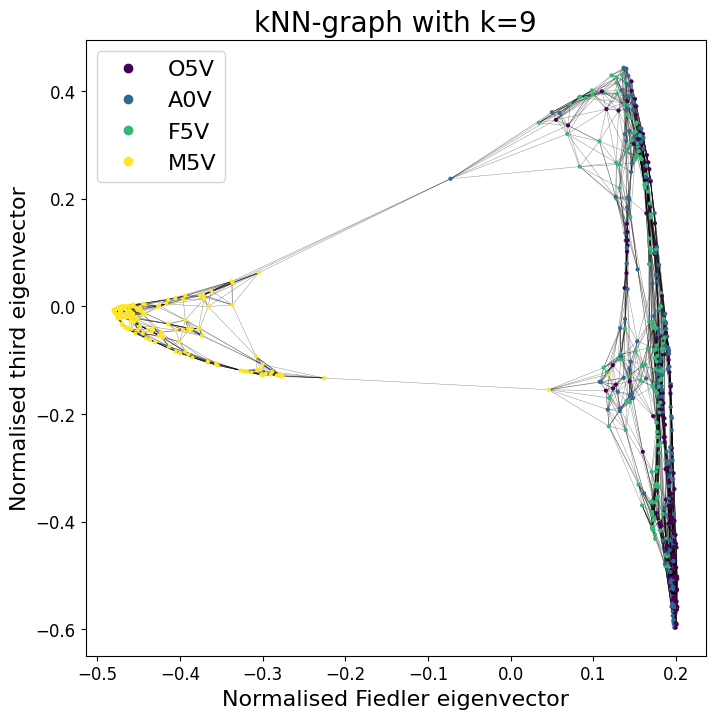

Algebraic connectivity (eigenvalue associated to the Fiedler eigenvector): 0.01


In [ ]:
# compute degrees
d = A.sum(axis=0)
# define diagonal degree matrix
D = np.diag(d)

# compute combinatorial Laplacian
L = D - A

# compute square root of inverse diagonal degree matrix
D_sqrt_inv = np.diag(1/np.sqrt(d))

# compute symmetric normalised Laplacian
L_s = D_sqrt_inv @ L @ D_sqrt_inv

# compute eigen decomposition using the fact that
eigenvals, eigenvecs = np.linalg.eigh(L_s)

# sort eigenvalues and corresponding eigenvector
eigenvecs = eigenvecs.T[np.argsort(eigenvals)]
eigenvals = np.sort(eigenvals)

# get second (Fiedler) and third eigenvectors
v2 = eigenvecs[1]
v3 = eigenvecs[2]

# normalise coordinates
x_coord = D_sqrt_inv @ v2
y_coord = D_sqrt_inv @ v3

# plot
fig,ax=plt.subplots(figsize=(8,8))

# plot edges
for i in tqdm(range(N)):
    for j in range(i+1,N):
        if A[i,j] > 0:
            ax.plot([x_coord[i],x_coord[j]],[y_coord[i],y_coord[j]], color="black", alpha=0.5, linewidth=0.3)

# plot nodes
scatter = ax.scatter(x_coord,y_coord,s=4, c=star_classes_train, zorder=10)


# create legend for node types
legend = plt.legend(handles=scatter.legend_elements()[0], labels=[value_to_type[c] for c in classes])

# set labels
ax.set(xlabel='Normalised Fiedler eigenvector', ylabel='Normalised third eigenvector',
    title=f'kNN-graph with k=9')
plt.show()
print(f'Algebraic connectivity (eigenvalue associated to the Fiedler eigenvector): {eigenvals[1]:.2f}')

Also this spectral layout shows a clear separation of class $M5V$ (for which the components of the normalised Fiedler eigenvector are negative) from the other classes (signalled by positive Fiedler eigenvector components). Indeed, if we used the Fiedler eigenvector to bipartition the graph, we would obtain one partition with the class $M5V$, and one partition with the other classes.  

The algebraic connectivity (the eigenvalue associated with the Fiedler eigenvector) is very small, indicating that the two partitions are weakly connected on the graph, confirming that class $M5V$ well clusters aprt from the other samples.

<a name="task-22"></a>

## (2.3) [(index)](#index-task-23)

The next step of the Isomap-like algorithm is to compute the resistance distance $R_{ij}$ between graph nodes $i$ and $j$, which is defined as:

$$
R_{ij} = \Gamma_{ii} + \Gamma_{jj} - 2\Gamma_{ij}
$$
where $\Gamma = (L - \frac{1}{N}\mathbf{1}\mathbf{1}^T)^+$, $+$ denotes the Moore–Penrose inverse and $L$ combinatorial graph Laplacian that I computed above.

For this, I use `np.linalg.pinv` to compute the pseudo-inverse.

In [ ]:
# compute gamma matrix
G = np.linalg.pinv(L-1/N*np.ones((N,N)), hermitian=True)

# compute resistance distance
D_res = np.zeros((N,N))

for i in range(N):
    for j in range(i,N):
        D_res[i,j] = G[i,i] + G[j,j] - 2 * G[i,j]
        D_res[j,i] = D_res[i,j]

I now compare the mean resistance distance per node (obtained by averaging over all distances to other nodes) and the mean cosine distance, drawing a scatter plot.

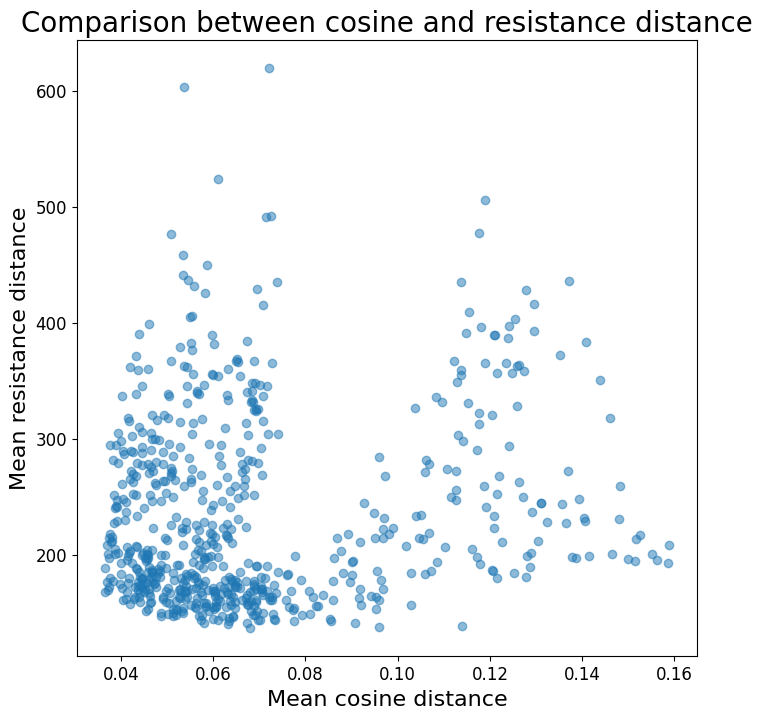

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(8,8))

# plot nodes
scatter = ax.scatter(np.mean(D_cos,axis=0),np.mean(D_res,axis=0),alpha=0.5)

# set labels
ax.set(xlabel='Mean cosine distance', ylabel='Mean resistance distance',
    title=f'Comparison between cosine and resistance distance')
plt.show()

The mean cosine distance values are concentrated in a narrow range (roughly below 0.16) compared to the mean resistance distance (which goes up to roughly 600). Indeed, the cosine distance i defined as $1-cos(\theta)$, where $\theta$ is the angle between two data vectors, its value is bounded at 1. Values closer to zero than to 1 indicate an overall similarity between data vectors (i.e., they tend to be parallel rather than orthogonal).

Resistance distance varies on a different scale, the scale of the size of the graph, as is defined in terms of the number and length of paths between two nodes in a graph.

Next I compute the matrix $\tau$ from the resistance distance matrix $R$:
$$
\tau = -\frac{HSH}{2} \quad \text{with} \quad H = I - \frac{1}{N}\mathbf{1}\mathbf{1}^T \quad \text{and} \quad S_{ij} = R_{ij}^2
$$
and take the first two eigenvectors of $\tau$ as the final embedding to visualise the result of Isomap.

In [ ]:
# define centering matrix
H = np.diag(np.ones(N)) - 1/N * np.ones((N,N))

# compute operator tau
tau = -H @ D_res**2 @ H/2

In [ ]:
# compute eigen-decomposition of tau
eigenvals_tau, eigenvecs_tau = np.linalg.eigh(tau)

# sort eigenvalues and corresponding eigenvector in decreasing order
eigenvecs_tau = eigenvecs_tau.T[np.argsort(-eigenvals_tau)]
eigenvals_tau = -np.sort(-eigenvals_tau)

# define 2D isomap embedding taking the two first eigenvectors
X_iso = eigenvecs_tau[:2].T

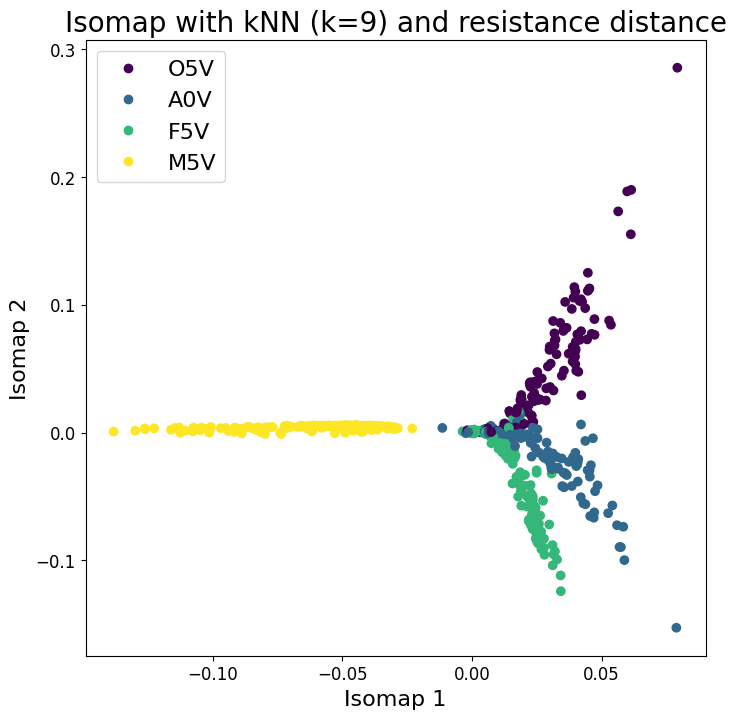

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
scatter = plt.scatter(X_iso[:,0], X_iso[:,1], c=star_classes_train)
legend = plt.legend(handles=scatter.legend_elements()[0], labels=[value_to_type[c] for c in classes])

for handle, label in zip(legend.legend_handles, star_classes_train):
    handle.set_label(label)
plt.xlabel('Isomap 1')
plt.ylabel('Isomap 2')
plt.title(f'Isomap with kNN (k={9}) and resistance distance')
plt.show()

The Isomap-like data dimensionality reduction, that I visualised in the $2D$ -space of the top two eigenvectors of the centred resistance distance matrix $\tau$, yields a much better-defined clustering of the $4$ star image classes.
Not only class $M5V$ clusters apart, as it was clear already with PCA and graph spectral partitioning, but also the other 3 classes are now more separated mong them.

I now compute the DB index.

 Evaluate how well this 2D representation matches the division into classes by calculating the  index, as in Task 2.1, and compare it to the results obtained from the 2D representation from PCA in Task 2.1. Discuss and explain the observed differences.


In [ ]:
db_isomap = davies_bouldin_index(X_iso, star_classes_train)
print(f'Davies bouldin index for the Isomap-like dimensionality reduction of star image embeddings: {db_isomap:.2f}')

Davies bouldin index for the Isomap-like dimensionality reduction of star image embeddings: 1.94


In [ ]:
db_table = pd.DataFrame({'Dimensionality reduction technique': ['PCA', 'Isomap-like'], 'DB Index': [db_pca, db_isomap]})
print(db_table.to_string(index=False))

Dimensionality reduction technique  DB Index
                               PCA  2.853370
                       Isomap-like  1.939467


As already clear from visual inspection, the Isomap-like lower-dimensional representation has better performance, in terms of clustering data consistently with their class, as quantified by the DB index: the DB index of the Isomap-like technique is lower than the one of PCA (with $1.94$ vs $2.85$).

The PCA lower-dimensional representation, indeed, tended to have larger within-cluster distances and lower between-cluster distances, especially for the 3 hard-to-classify classes O5V, A0V, F5V.


Presumably, the Isomap-like method performs better than PCA because it's a non-linear dimensionality reduction method (while PCA is linear), i.e., to obtain a representation separating the classes O5V, A0V, F5V one needs to capture non-linear relationships between data features and have a notion of distance between data points that takes them into account. The graph construction and the use of a distance metric defined on a graph are better suited for this task, because a graph is a way of obtaining a discrete approximation of the underlying manifold of the data. Then, the embedding chosen preserves distances on this graph, helping capture and visualise the relationships induced by the data manifold.